# Ensembles, Random Forest
**Author**: Maria Tikhonova



In [1]:
%matplotlib inline

import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.datasets import fetch_california_housing
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import graphviz
import pydotplus

from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")


# Increase viewable area of Pandas tables, numpy arrays, plots

np.set_printoptions(linewidth=10000, precision=4, edgeitems=20, suppress=True)
sns.set()
plt.rcParams['figure.figsize'] = [16, 6]

# 1. Ансамбли

### Data  - Titanic data set

Сегодня будем работать с данными о пассажирах Титаника (Titatic dataset).

In [2]:
#data = pd.read_csv('titanic.csv')
data = pd.read_csv('https://grantmlong.com/data/titanic.csv')
cols_2_drop = ['PassengerId', 'Ticket', 'Cabin', 'Name']
data = data.drop(cols_2_drop, axis=1)
data.loc[:, 'Age'] = data.Age.fillna(-999)
data = data.dropna()
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


Пропусков в данных нет, но есть 2 категориальных признака (`Sex`,`Embarked`). Закодируем их с помощью `OrdinalEncoder`.

In [4]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
data[['Sex','Embarked']] = enc.fit_transform(data[['Sex','Embarked']])
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1.0,22.0,1,0,7.2500,2.0
1,1,1,0.0,38.0,1,0,71.2833,0.0
2,1,3,0.0,26.0,0,0,7.9250,2.0
3,1,1,0.0,35.0,1,0,53.1000,2.0
4,0,3,1.0,35.0,0,0,8.0500,2.0


In [5]:
X = data.drop('Survived', axis=1)
Y = data['Survived']
#Train test split
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=2)
train_X.shape, test_X.shape, train_Y.shape, test_Y.shape

((711, 7), (178, 7), (711,), (178,))

## Recap: высокий разброс решающих деревьев

Деревья решений обладают **высоким разбросом (high variance)**. Небольшие колебания в данных могут привести к сильным измениниям в получившихся обученных деревьях.

In [6]:
def plot_tree(model, X, fname='temp_tree.png'):
    dot_data = export_graphviz(model, filled=True, rounded=True, feature_names=X.columns, out_file=None)
    pydot_graph = pydotplus.graph_from_dot_data(dot_data)
    pydot_graph.write_png(fname)
    img = plt.imread(fname)
    plt.imshow(img)

In [7]:
# Random state affects the order at which predictors are considered. At each split the predictors are randomly permuted
tree1 = DecisionTreeClassifier(random_state=0, max_depth=3)
tree1.fit(train_X, train_Y)
tree1_r2 = r2_score(tree1.predict(test_X), test_Y)
tree1_accuracy = accuracy_score(tree1.predict(test_X), test_Y)
print(f'Accuracy for the first tree: {tree1_accuracy:.4f}')

train_X_2, test_X_2, train_Y_2, test_Y_2 = train_test_split(X, Y, test_size=0.2, random_state=7)

tree2 = DecisionTreeClassifier(random_state=0, max_depth=3)
tree2.fit(train_X_2, train_Y_2)

tree2_accuracy = accuracy_score(tree2.predict(test_X_2), test_Y_2)

print(f'Accuracy for the second tree: {tree2_accuracy:.4f}')

Accuracy for the first tree: 0.7753
Accuracy for the second tree: 0.7978


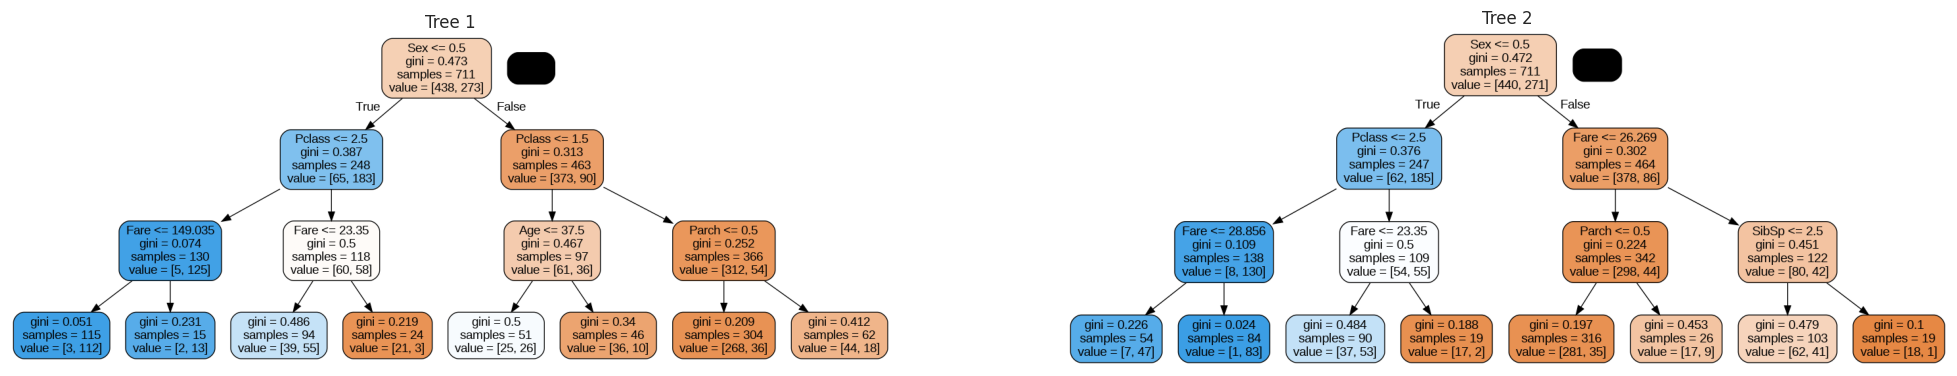

In [8]:
plt.figure(figsize=(25, 15))
plt.subplot(1, 2, 1)
plot_tree(tree1, train_X)
plt.axis('off')
plt.title(f'Tree 1')
plt.subplot(1, 2, 2)
plot_tree(tree2, train_X_2)
plt.axis('off')
plt.title(f'Tree 2')
plt.show()

Мы отправили в тест лишь 20% данных, а деревья получились очень разными!

И при увеличении глубины дерева становится только хуже.

## Bagging
Вместо того, чтобы обучить одно дерево решений, обучим ансамбль по следующему алгоритму:

1. Сгенерируем $B$ бутсрэп выборок (сэмплирование с возвращением, помните?) из обучающего набора данных.
2. Обучим $B$ решающих деревьев $f_1, f_2, \dots, f_B$ на каждой из бутсреп подвыборок.
3. В качестве предсказания на тестовых данных возьмем среднее предсказание алгорима $\hat{y} = 1/B \sum_{i=0}^{B} f_i(x)$ (для задачи классификации возьмем наиболее популярный класс).


In [9]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=2)

In [10]:
# BaggingRegressor can be used with any model, not only decision trees

model = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_jobs=-1, n_estimators=100)
model.fit(train_X, train_Y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                  n_estimators=100, n_jobs=-1)

In [11]:
print(f'Bagged trees accuracy score {accuracy_score(model.predict(test_X), test_Y):.4f}')


Bagged trees accuracy score 0.8034


Можем посмотреть на отдельные деревья.

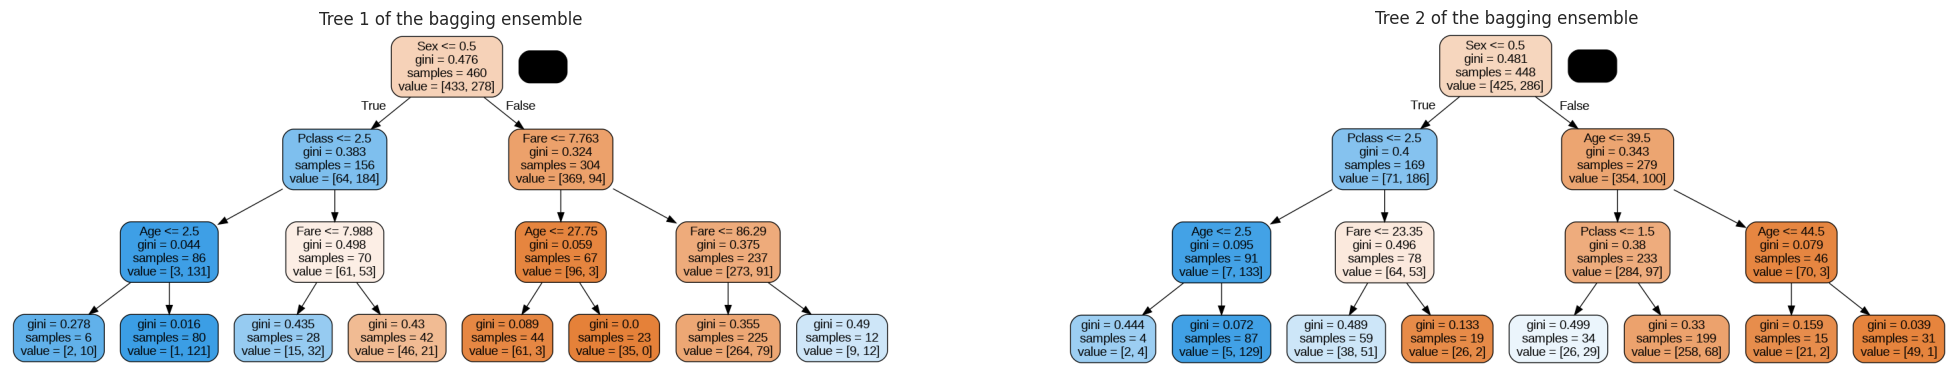

In [12]:
tree1, tree2 = model.estimators_[0], model.estimators_[1]

plt.figure(figsize=(25, 15))
plt.subplot(1, 2, 1)
plot_tree(tree1, train_X)
plt.axis('off')
plt.title(f'Tree 1 of the bagging ensemble')
plt.subplot(1, 2, 2)
plot_tree(tree2, train_X)
plt.axis('off')
plt.title(f'Tree 2 of the bagging ensemble')
plt.show()

Процесс обучения бэггинг ансамбля позволяет оценивать тестовую ошибку без кросс-валидации. Вспомним, что каждое дерево обучается на помножестве train'овых данных.

Для каждого примера $x_i$ сделаем предсказания с использованием тех деревьев, которые не использовали $x_i$ при обучении. Затем усредним предсказания и посчитаем ошибку. Получим робастную оценку тестовой ошибки.

In [13]:
model = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=None), n_jobs=-1, n_estimators=20, oob_score=True)
model.fit(train_X, train_Y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=20,
                  n_jobs=-1, oob_score=True)

In [14]:
print(f'Test score estimate using Out-of-bag score {model.oob_score_:.4f}')
print(f'Test score estimate using Cross-Validation {cross_val_score(model, train_X, train_Y, scoring="accuracy").mean():.4f}')
print(f'Actual test score: {accuracy_score(model.predict(test_X), test_Y):.4f}')
print(f'Train score: {accuracy_score(model.predict(train_X), train_Y):.4f}')

Test score estimate using Out-of-bag score 0.8031
Test score estimate using Cross-Validation 0.8129
Actual test score: 0.7753
Train score: 0.9761


## Random Forests
Деревья в бэггинг ансамблях зачастую сильно **коррелируют** между собой. Они очень похожи, так как обучаются на похожих выборках. Когда мы агрегируем предсказания похожих деревьев, мы не так сильно уменьшаем разброс (variance), как нам бы хотелось.

Как уменьшить корреляцию деревьев?

**Solution: Random Forest!** Построим ансамбль деревьев определенным образом. Каждый раз, когда будем выбирать сплит при обучении, будем перебирать только $m$ случайно выбранных признаков из $p$, при этом $m < p$.

In [15]:
RandomForestClassifier?

In [16]:
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth = 3, oob_score=True)
model.fit(train_X, train_Y)

RandomForestClassifier(max_depth=3, n_jobs=-1, oob_score=True)

In [17]:
print(f'Test score estimate using Out-of-bag score {model.oob_score_:.4f}')
print(f'Actual test score: {accuracy_score(model.predict(test_X), test_Y):.4f}')

Test score estimate using Out-of-bag score 0.7876
Actual test score: 0.8258


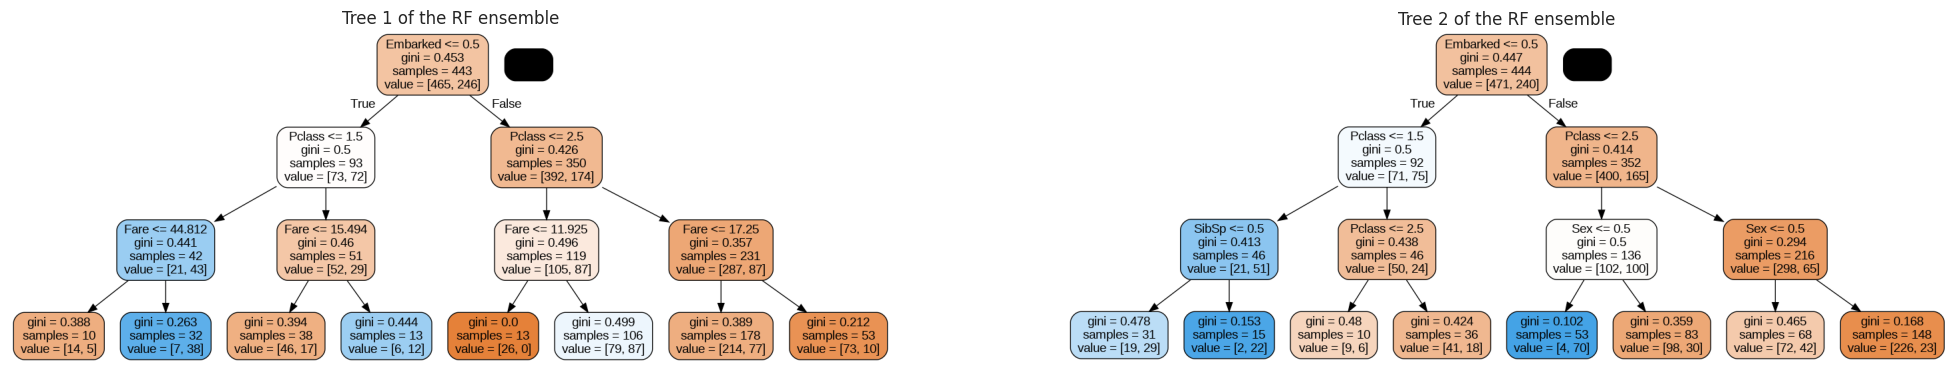

In [18]:
tree1, tree2 = model.estimators_[0], model.estimators_[1]

plt.figure(figsize=(25, 15))
plt.subplot(1, 2, 1)
plot_tree(tree1, train_X)
plt.axis('off')
plt.title(f'Tree 1 of the RF ensemble')
plt.subplot(1, 2, 2)
plot_tree(tree2, train_X)
plt.axis('off')
plt.title(f'Tree 2 of the RF ensemble')
plt.show()

In [19]:
# Now lets try realistic max_depth
model = RandomForestClassifier(n_estimators=500, n_jobs=-1, max_depth = None, oob_score=True)
model.fit(train_X, train_Y)
print(f'Test score estimate using Out-of-bag score {model.oob_score_:.4f}')
print(f'Actual test score: {accuracy_score(model.predict(test_X), test_Y):.4f}')
print(f'Train score: {accuracy_score(model.predict(train_X), train_Y):.4f}')


Test score estimate using Out-of-bag score 0.8073
Actual test score: 0.8202
Train score: 0.9831


## Важность признаков (feature importance)

Для каждого дерева, для признака можно посчитать прирост информации (information gain), полученный при разбиении по этому признаку. Это и есть мера важности признака.



In [20]:
feature_importances = zip(train_X.columns, model.feature_importances_)
list(feature_importances)

[('Pclass', 0.08890881591215859),
 ('Sex', 0.25226959926849735),
 ('Age', 0.24322798657087805),
 ('SibSp', 0.05175369795429264),
 ('Parch', 0.04771132126726734),
 ('Fare', 0.27886772833387957),
 ('Embarked', 0.03726085069302659)]

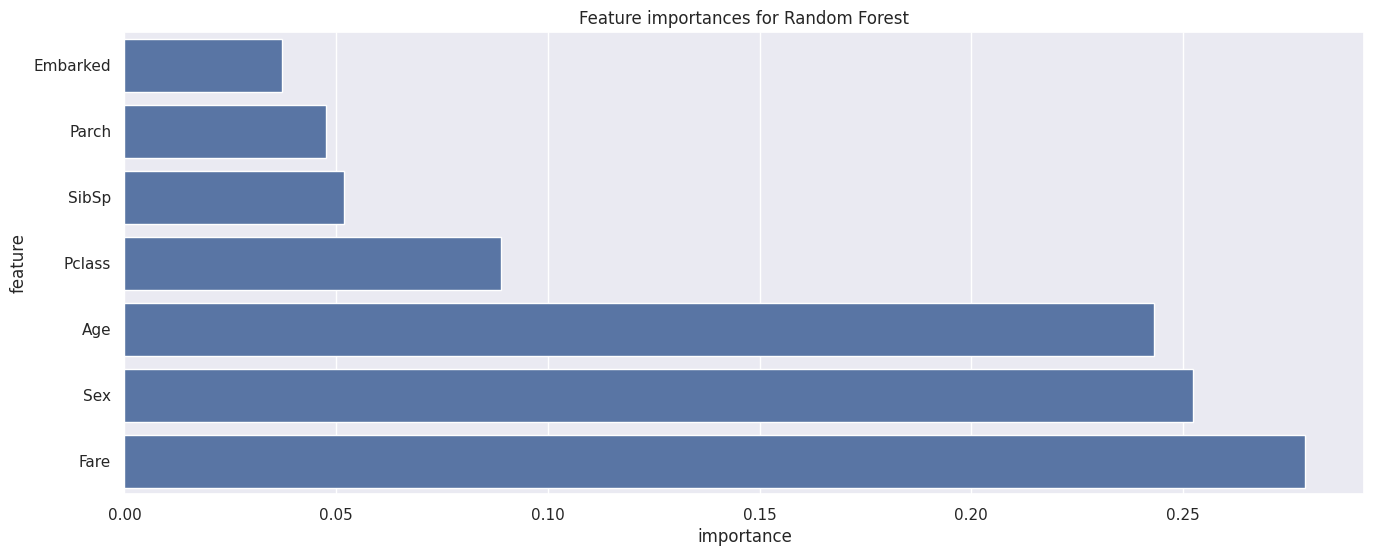

In [21]:
feature_importances = zip(train_X.columns, model.feature_importances_)
feature_importances = sorted(feature_importances, key=lambda x: x[1])
feature_importances = pd.DataFrame(feature_importances, columns=['feature', 'importance'])

plt.title('Feature importances for Random Forest')
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.show()

## Tuning

Основные фичи, которые можно тюнить:
* `n_estimators` - число деревьев,
* `max_samples` - число сэмплов в бутсреп выборке,
* `max_features` - число признаков, которое рассматривается при разбиении,
* `max_depth` - максимальная глубина дерева.


Больше информации можно найти [тут](https://dyakonov.org/2016/11/14/%D1%81%D0%BB%D1%83%D1%87%D0%B0%D0%B9%D0%BD%D1%8B%D0%B9-%D0%BB%D0%B5%D1%81-random-forest/).

In [22]:
GridSearchCV?

In [23]:
parameters = {'n_estimators': [5,10,50, 100, 500], 'max_features' : [None, 3], 'max_depth':[None, 3, 5, 10]}

model = RandomForestClassifier()
clf = GridSearchCV(model, parameters, scoring = 'accuracy')

clf.fit(train_X, train_Y)
pred = clf.predict(test_X)
print(f'Actual test score: {accuracy_score(pred, test_Y):.4f}')
print('Best parameters: ', clf.best_params_)

Actual test score: 0.8258
Best parameters:  {'max_depth': 10, 'max_features': 3, 'n_estimators': 500}


Кроме регрессии и классификации random forest используется для:
* Кластеризации
* Детекции аномалий
* Отбора признаков

и не только!

# Градиентный бустинг

Градиентный бустинг - метод ансамблирования, который последовательно строит деревья решений (базовые алгоритмы в общем случае) так, чтобы каждое следующее дерево исправляло ошибку предыдущих.

При этом мы строим **неглубокие деревья** максимальной высоты, обычно не глубже 3-7.

**Вопрос:** как вы думаете почему?

Общее число деревьев это гиперпараметр $B$.

Помимо этого часто мы хотим, чтобы каждое следующее дерево исправляло лишь часть ошибки. Для этого мы используем гиперпараметр $\lambda$. Поскольку на $\lambda$ мы умножаем предсказания каждого дерева, то необходимо чтобы $\lambda < 1$. Обычно берут $\lambda = 0.01$ или меньше.

# Алгоритм

* Применение дерева решений на данных
* Вычисление погрешности ошибок. Фактическое целевое значение, минус прогнозируемое целевое значение

$$e_1 = y\ — y\_pred_1$$
* Установка новой модели для отклонений в качестве целевой переменной с одинаковыми входными переменными
$$y_2\_pred$$
где $y_2\_pred$ - предсказания для погрешности ошибки с предыдущего шага - $e_1$
* Добавление предсказанных отклонений к предыдущим прогнозам $y\_pred\_total = y\_pred_1 + y_2\_pred$
* Установка еще одной модели оставшихся отклонений $e_2 = y\ — y\_pred\_total$

## Связь с градиентными методами

$$L_{MSE} = \frac{1}{2}(y - f(x))^2$$


$$e_m(x) = - \frac{dL}{f} = y - f(x)$$

Про математику, стоящую за градиентным бустингом можно прочитать в [посте](https://habr.com/ru/company/ods/blog/327250/).

## Sklearn

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_hastie_10_2
from sklearn.metrics import roc_auc_score

n_estimators = 200

X, y = make_hastie_10_2(n_samples=10000)
X_test, y_test = make_hastie_10_2(n_samples=10000)
est = GradientBoostingClassifier(n_estimators=200, max_depth=3)
est.fit(X, y)

pred = est.predict(X)
est.predict_proba(X)[0]
print('accuracy', round(accuracy_score(y_test, est.predict(X_test)),3))

accuracy 0.935


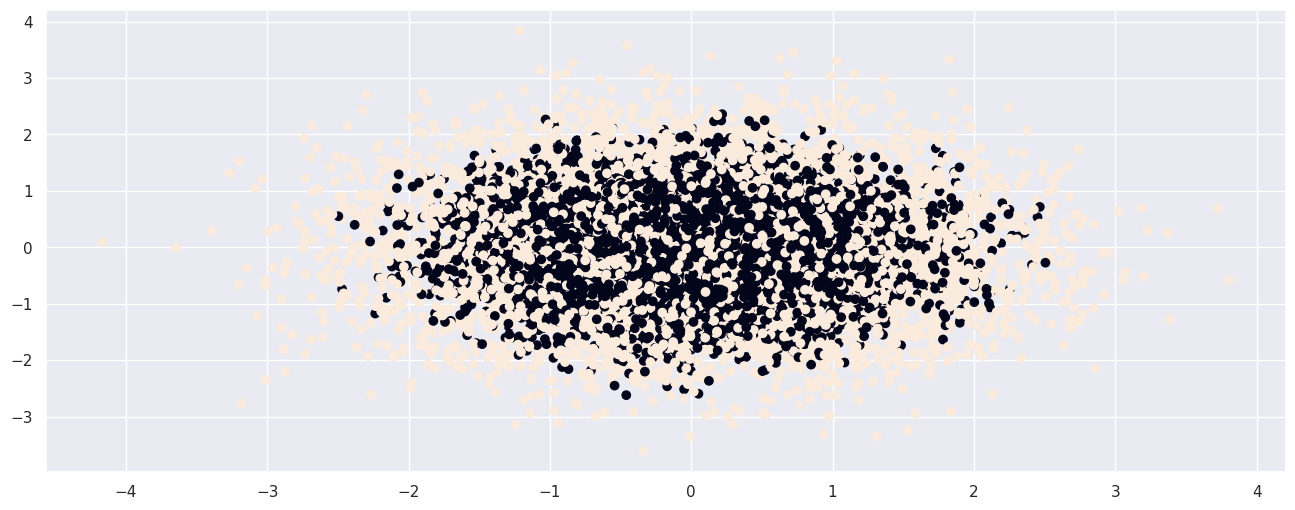

In [25]:
plt.scatter(X[:, 0], X[:, 2], c=y)

In [26]:
X.shape

(10000, 10)

## Современные библиотеки Градиентного Бустинга

До этого мы использовали достаточно простенькую реализацию в sklearn.

Сегодня есть ряд более продвинутых имплементаций, наиболее популярные из которых:
* **XGBoost**. После появления очень быстро завоевал популярность и оставался стандартом до 2016 года. Сегодня считается немного устарелым
* **LightGBM**. Ускоренная версия XGBoost, которая сегодня является самой популярной в Kaggle-соревнованиях.
* **CatBoost**. Библиотека от Яндекса. Умеет работать с категориальными фичами.

Посмотрим на работу LightFM и Catboost.

## LightGBM


In [27]:
from sklearn.datasets import make_classification
from matplotlib.colors import ListedColormap

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def plot_surface(X, y, clf):
    h = 0.2
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

X, y = make_classification(n_samples=500, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.8, random_state=241)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=241)

In [28]:
!pip install lightgbm

In [29]:
from lightgbm import LGBMClassifier # sklearn-like API, but it's not the only one available
import lightgbm as lgb

[LightGBM] [Info] Number of positive: 172, number of negative: 178
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 235
[LightGBM] [Info] Number of data points in the train set: 350, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491429 -> initscore=-0.034289
[LightGBM] [Info] Start training from score -0.034289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

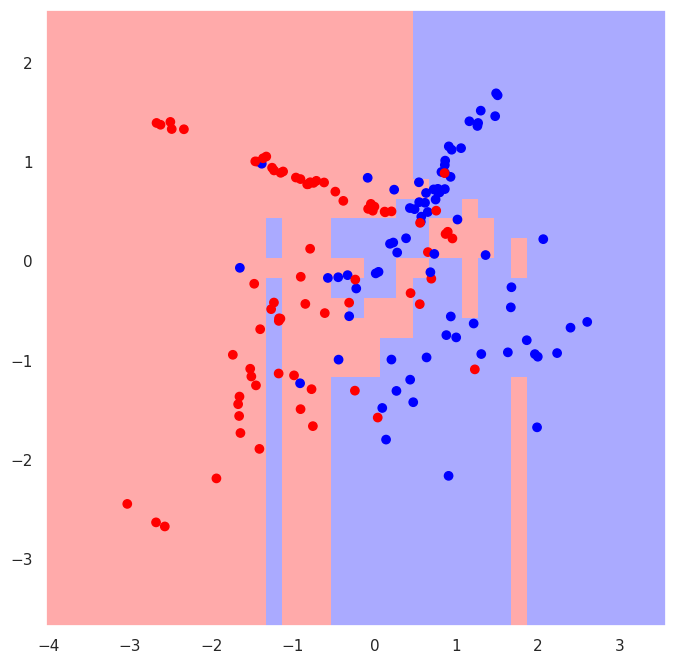

In [30]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(n_estimators=300)
clf.fit(X_train, y_train)
plot_surface(X_test, y_test, clf)

print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

[LightGBM] [Info] Number of positive: 172, number of negative: 178
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 235
[LightGBM] [Info] Number of data points in the train set: 350, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491429 -> initscore=-0.034289
[LightGBM] [Info] Start training from score -0.034289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 172, number of negative: 178
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 235
[LightGBM] [Info] Number of data points in the train set: 350, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491429 -> initscore=-0.034289
[LightG

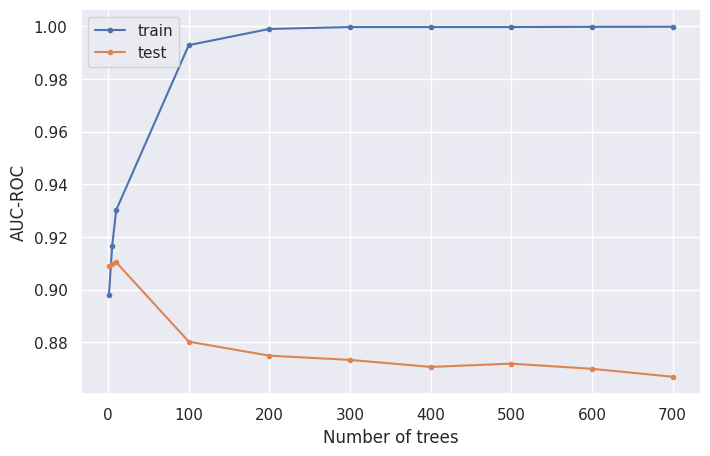

In [31]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals_train = []
quals_test = []
for n in n_trees:
    clf = LGBMClassifier(n_estimators=n)
    clf.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)

plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

## Catboost

In [32]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.6 MB/s eta 0:00:00


0.919452347083926


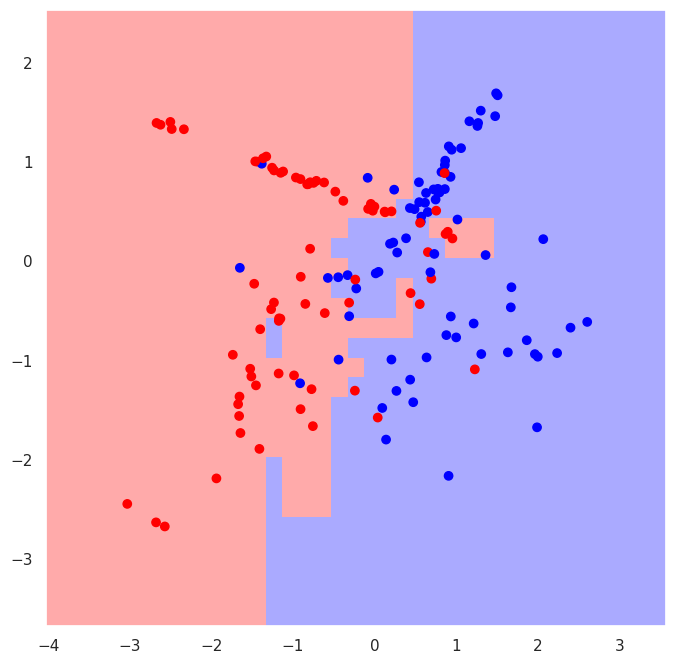

In [33]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(iterations=300, logging_level='Silent')
clf.fit(X_train, y_train)
plot_surface(X_test, y_test, clf)

print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

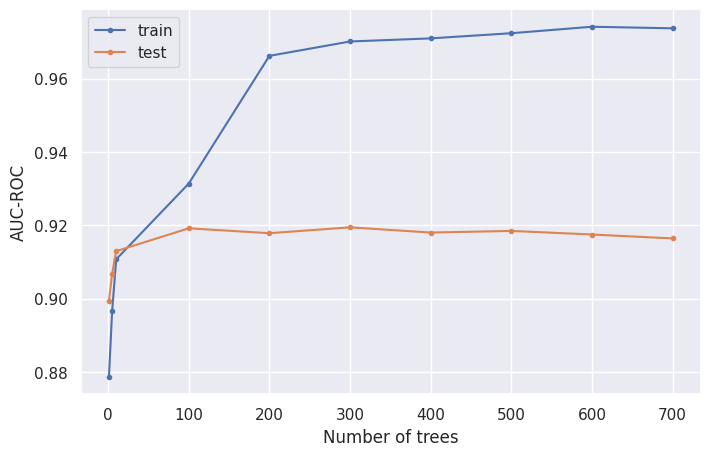

In [34]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals_train = []
quals_test = []
for n in n_trees:
    clf = CatBoostClassifier(iterations=n, logging_level='Silent')
    clf.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)

plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

Вау! Впечатляет! Бустинг и правда мощная штука!

In [35]:
CatBoostClassifier?